In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
import numpy as np
import random
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split      # dividing the dataset
import tensorflow as tf
import cv2


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
 
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint ,Callback # type: ignore
from tensorflow.keras import layers, models ,optimizers # type: ignore
from tensorflow.keras.models import load_model, Model # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense # type: ignore
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2 # type: ignore
import pathlib


import warnings
warnings.filterwarnings("ignore")



Exploratory data analysis 

In [2]:
# Basic review of the images directory

def dataset_analysis(path):
    subfolders = os.listdir(path)
    print(f"Four conditions : ", subfolders)
    i=0
    total_images = 0
    image_extensions=['.jpg', '.jpeg', '.png']
    
    for root, dirs, files in os.walk(path):
        for file in files:
            # Check if the file has a valid image extension
            if any(file.lower().endswith(ext) for ext in image_extensions):
                total_images += 1
    
    print(f"Total number of images: {total_images}")
        
    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            files = os.listdir(subfolder_path)
            format_dimensions_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

            for file in files:
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        image_type = img.format.upper()  # Format (e.g., JPEG, PNG)
                        image_dimensions = img.size  # (width, height)
                        image_mode = img.mode  #  (e.g., RGB, L)
                        
                        # Calculate bit depth
                        if image_mode == "1":  # 1-bit pixels, black and white, stored with one pixel per byte
                            bit_depth = 1
                        elif image_mode == "L":  # 8-bit pixels, grayscale
                            bit_depth = 8
                        elif image_mode == "P":  # 8-bit pixels, mapped to any other mode using a color palette
                            bit_depth = 8
                        elif image_mode == "RGB":  # 8-bit pixels, true color
                            bit_depth = 24  # 8 bits per channel
                        elif image_mode == "RGBA":  # 8-bit pixels, true color with transparency mask
                            bit_depth = 32  # 8 bits per channel
                        elif image_mode == "CMYK":  # 8-bit pixels, color separation
                            bit_depth = 32  # 8 bits per channel
                        else:
                            bit_depth = "Unknown"
                        
                        format_dimensions_counts[image_type][(image_dimensions, bit_depth)][image_mode] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")
                    
            print('--------'*10)
            i=i+1
            print(f" {i}- '{subfolder}': {len(files)}")
            for format, dimensions_counts in format_dimensions_counts.items():
                print(f"   * {sum(sum(counts.values()) for counts in dimensions_counts.values())} images of format {format}:")
                for (dimensions, bit_depth), counts in dimensions_counts.items():
                    for mode, count in counts.items():
                        print(f"     - {count} images with dimensions {dimensions}, bit depth {bit_depth}, mode {mode}")
                        
dataset_path = 'C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/'
dataset_analysis(dataset_path)


Four conditions :  ['Cataract', 'diabetic_retinopathy', 'Glaucoma', 'Normal']
Total number of images: 4217
--------------------------------------------------------------------------------
 1- 'Cataract': 1038
   * 938 images of format JPEG:
     - 298 images with dimensions (512, 512), bit depth 24, mode RGB
     - 640 images with dimensions (256, 256), bit depth 24, mode RGB
   * 100 images of format PNG:
     - 18 images with dimensions (1594, 1594), bit depth 24, mode RGB
     - 14 images with dimensions (1590, 1590), bit depth 24, mode RGB
     - 5 images with dimensions (1586, 1586), bit depth 24, mode RGB
     - 2 images with dimensions (1196, 1196), bit depth 24, mode RGB
     - 1 images with dimensions (1592, 1566), bit depth 24, mode RGB
     - 1 images with dimensions (1592, 1565), bit depth 24, mode RGB
     - 22 images with dimensions (1596, 1596), bit depth 24, mode RGB
     - 8 images with dimensions (1588, 1588), bit depth 24, mode RGB
     - 22 images with dimensions (1

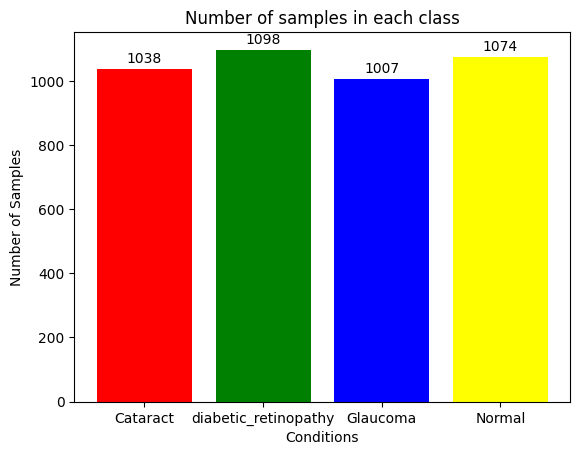

In [8]:
# Count the number of images in each directory
subfolders = os.listdir(dataset_path)

image_counts = []
for directory in subfolders:
    sub_dir = os.path.join(dataset_path, directory)
    if os.path.isdir(sub_dir):
        file_count = len(os.listdir(sub_dir))
        image_counts.append(file_count)
        
#Add value counts on each bar
for i in range(len(subfolders)):
    plt.text(i, image_counts[i]+10, str(image_counts[i]), ha='center', va='bottom')
    
#Set some colors
colors = ['Red', 'Green', 'Blue', 'yellow']
#Condi = ['Cataract', 'DR', 'Glaucoma', 'Normal']
 
# Plotting the results
plt.bar(subfolders, image_counts, color=colors)
plt.xlabel('Conditions')
plt.ylabel('Number of Samples')
plt.title('Number of samples in each class')
plt.show()

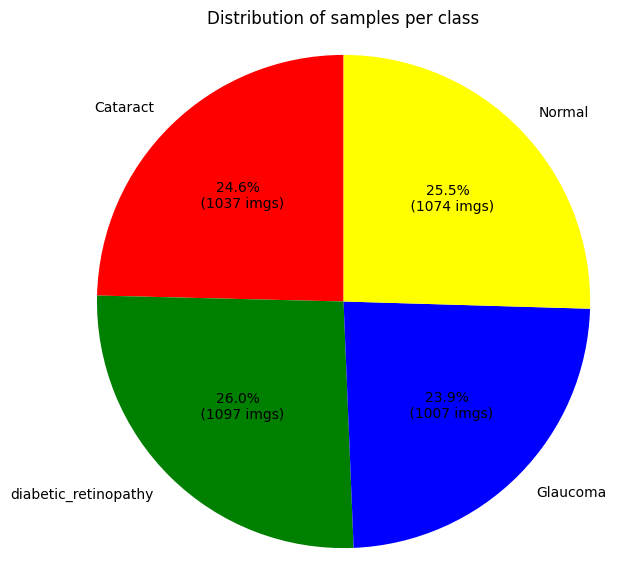

In [5]:
# # Calculate the number of images per class
# class_counts = df['class'].value_counts()
# 
# # Get the encoded labels and corresponding image counts
# class_sizes = class_counts.values  # Number of images in each class
# 
# # Use LabelEncoder to get the original class names (before encoding)
# class_labels = label_encoder.inverse_transform(class_counts.index)

# Custom function to display both the number of images and percentage
def autopct_format(pct, sizes):
    total = sum(sizes)
    actual = int(total * pct / 100)  # Directly calculate the actual number of images
    return f"{pct:.1f}% \n ({actual} imgs)"  # Format: percentage and image count

# Plot the pie chart
plt.figure(figsize=(7, 7))  # Adjust the figure size
plt.pie(image_counts, labels=subfolders, autopct=lambda pct: autopct_format(pct, image_counts),
        startangle=90, colors=colors)

# Add a title
plt.title('Distribution of samples per class')

# Ensure the pie chart is a circle
plt.axis('equal')

# Display the plot
plt.show()


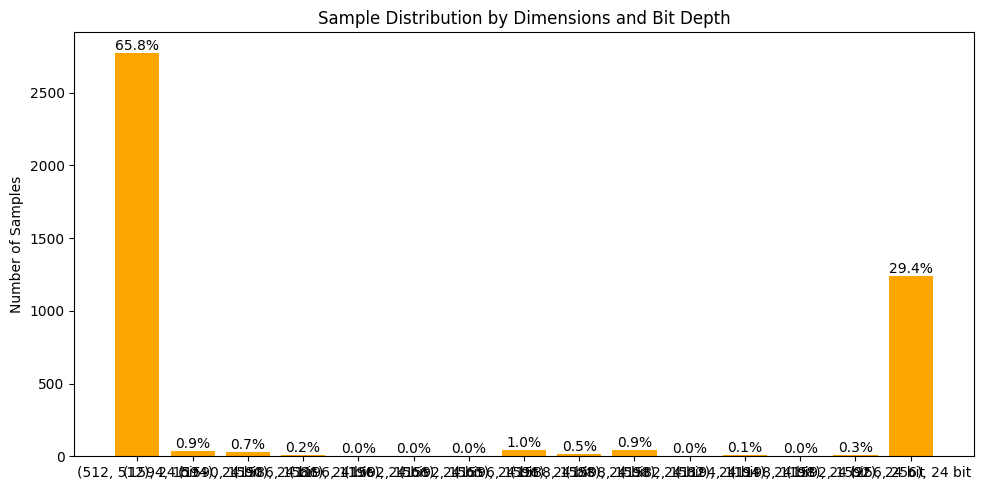

In [6]:
# Check the photos by size

def dataset_size_analysis(path):
    format_dimensions_counts = defaultdict(int)

    subfolders = os.listdir(path)
    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            files = os.listdir(subfolder_path)

            for file in files:
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        image_dimensions = img.size
                        image_mode = img.mode

                        # Calculate bit depth
                        bit_depth = {
                            "1": 1,
                            "L": 8,
                            "P": 8,
                            "RGB": 24,
                            "RGBA": 32,
                            "CMYK": 32
                        }.get(image_mode, "Unknown")

                        # Update counts
                        format_dimensions_counts[(image_dimensions,bit_depth)] += 1

                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

    # Plotting dimensions and bit depths
    plt.figure(figsize=(10, 5))
    labels = [f"{dims}, {depth} bit" for (dims, depth) in format_dimensions_counts]
    sizes = list(format_dimensions_counts.values())
    total = sum(sizes)
    bars = plt.bar(labels, sizes, color='Orange')
   # plt.xticks(rotation=45, ha="right")
    plt.ylabel('Number of Samples')
    plt.title('Sample Distribution by Dimensions and Bit Depth')

    # Adding percentage labels above the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{100 * yval/total:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_size_analysis(dataset_path)

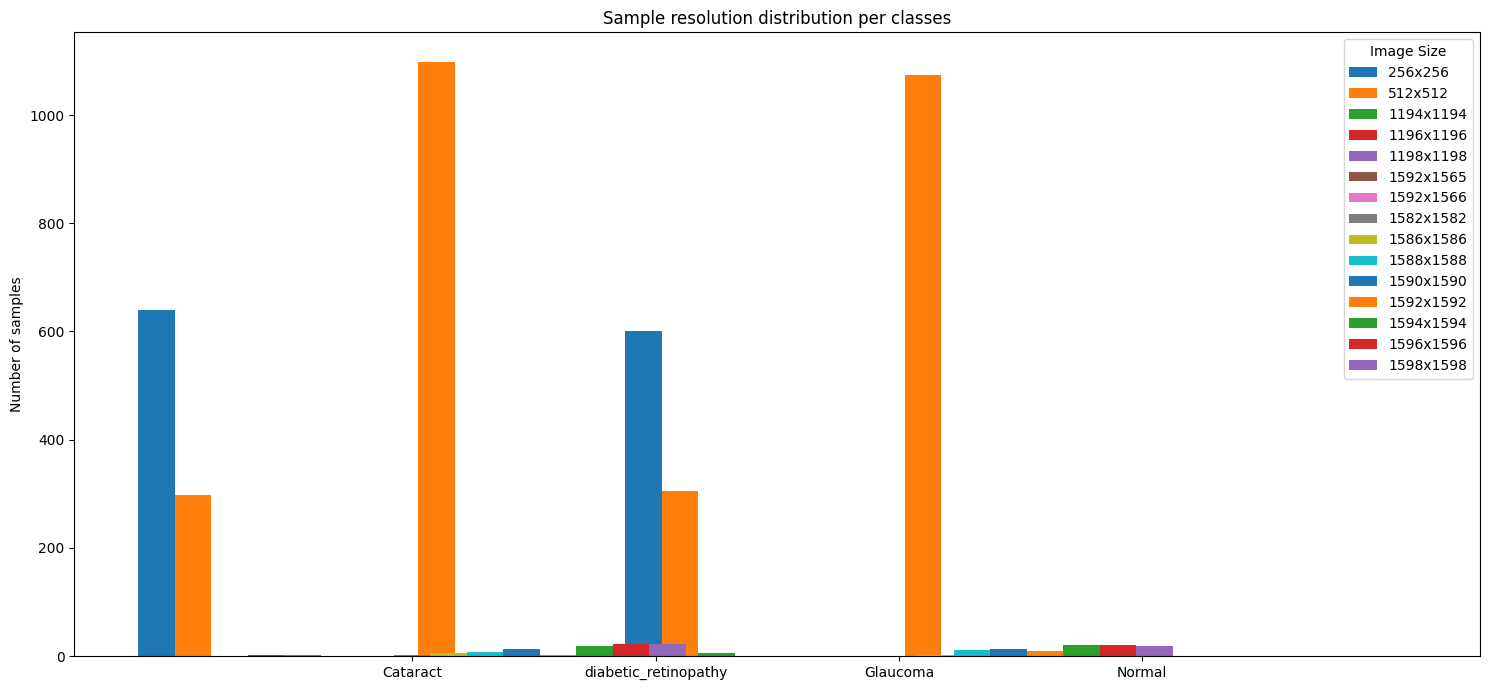

In [7]:
#Sample resolution distribution per classes

def dataset_size_analysis(path):
    # Dictionary to store counts: {subfolder: {image_size: count}}
    folder_size_counts = defaultdict(lambda: defaultdict(int))

    for subfolder in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        dims = img.size
                        folder_size_counts[subfolder][dims] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

    # Create a single plot
    plt.figure(figsize=(15, 7))
    
    # Determine unique image sizes across all folders for consistent coloring and grouping
    all_sizes = set(size for sizes in folder_size_counts.values() for size in sizes)
    all_sizes = sorted(all_sizes, key=lambda s: (s[0] * s[1]))  # Sort by area

    subfolder_names = list(folder_size_counts.keys())
    bar_width = 0.15  # Width of bars
    indices = range(len(subfolder_names))

    for i, size in enumerate(all_sizes):
        counts = [folder_size_counts[subfolder].get(size, 0) for subfolder in subfolder_names]
        plt.bar([index + i * bar_width for index in indices], counts, bar_width, label=f'{size[0]}x{size[1]}')

    plt.xticks([index + (len(all_sizes) - 1) * bar_width / 2 for index in indices], subfolder_names, ha="center")
    plt.ylabel('Number of samples')
    plt.title('Sample resolution distribution per classes')
    plt.legend(title="Image Size")
    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_size_analysis(dataset_path)


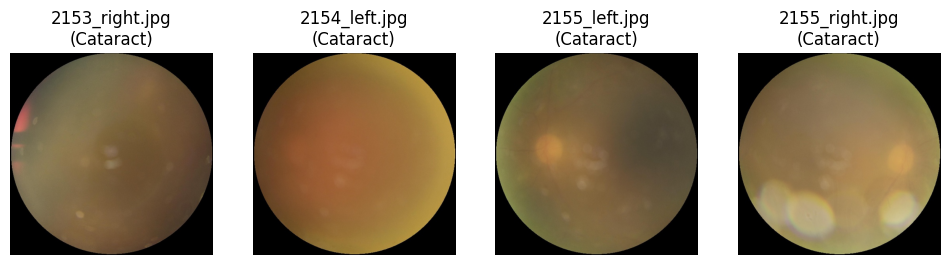

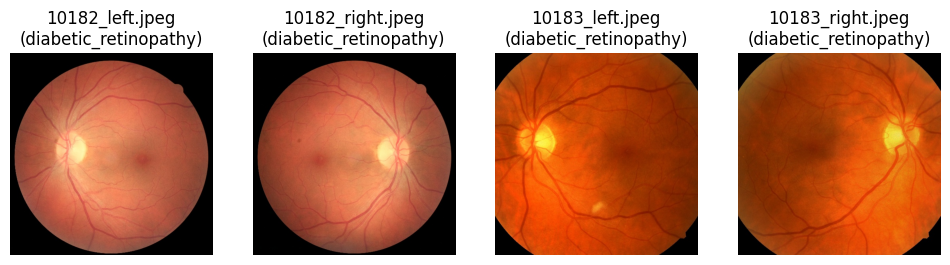

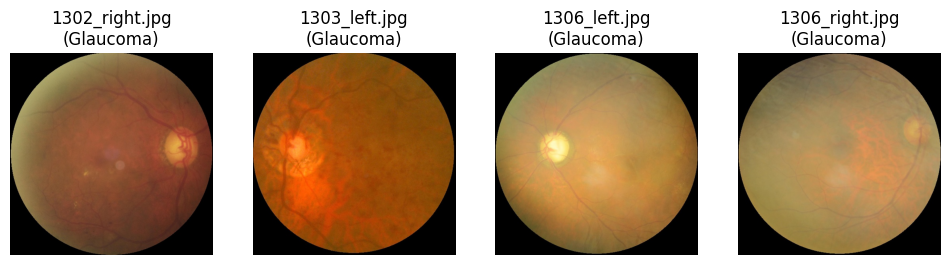

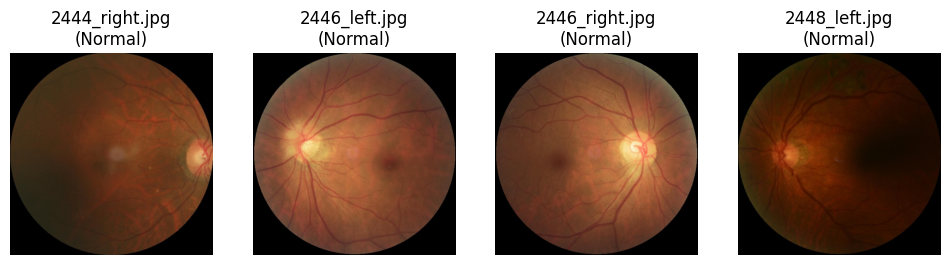

In [8]:
def preview_photos_from_folders(base_folder, start_index=100, num_images=4):
    # Walk through all directories and files in the base_folder
    for root, dirs, files in os.walk(base_folder):
        # Filter to get only files that are images
        images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Check if there are enough images to display starting from start_index
        if len(images) > start_index:
            # Select 4 images starting from start_index
            selected_images = images[start_index:start_index + num_images]  
            
            # Display selected images
            fig, axs = plt.subplots(1, num_images, figsize=(12, 3))  # Create a 1xN grid of plots
            for idx, img_name in enumerate(selected_images):
                img_path = os.path.join(root, img_name)
                img = Image.open(img_path)
                axs[idx].imshow(img)
                axs[idx].axis('off')  # Hide axes
                
                # Extract sub-folder name from the root path
                subfolder_name = os.path.basename(root)
                # Set the title to include image name and sub-folder name
                axs[idx].set_title(f"{img_name}\n({subfolder_name})")
                
            plt.show()

# Path to the folder containing sub-folders with images
preview_photos_from_folders(dataset_path, start_index=120, num_images=4)


Data preparation

In [3]:
# Get the names of the classes
class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Create data path and their labels
data = []  # List to store the image paths
labels = []  # List to store the class labels
extensions = ["jpg", "jpeg", "png", "bmp", "gif"]  # Lowercase to standardize extensions

for class_label in class_dirs:
    for ext in extensions:
        # Search for files with each extension and append both data and label simultaneously
        image_files = glob.glob(os.path.join(dataset_path, class_label, f"*.{ext.lower()}"))
        data.extend(image_files)  # Append image paths
        labels.extend([class_label] * len(image_files))  # Append corresponding labels
        data = ([os.path.normpath(p).replace('\\', '/') for p in data])
 
# Check if lists are empty
if not data:
    print("No files were found. Check your directory paths and file formats.")
else:
    print(f"Found {len(data)} images in total.")

# Create a Pandas DataFrame
df = pd.DataFrame({
    'filename': data,
    'class': labels
})

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

# Display DataFrame
print(df.head())  # Display the first few rows of DataFrame
print(df['class'].value_counts())  # Display the distribution of images across classes
 
# Save the DataFrame to a CSV file
try:
    output_csv_path = 'C:/Users/PC_I/OneDrive/Desktop/your_dataframe2.csv'
    df.to_csv(output_csv_path, index=False)
    print(f"DataFrame saved successfully to {output_csv_path}")
except PermissionError as e:
    print(f"PermissionError: {e}")
    print("Try saving to a different directory.")



Found 4217 images in total.
                                            filename                 class
0  C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/dia...  diabetic_retinopathy
1  C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Gla...              Glaucoma
2  C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Nor...                Normal
3  C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Cat...              Cataract
4  C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Gla...              Glaucoma
class
diabetic_retinopathy    1098
Normal                  1074
Cataract                1038
Glaucoma                1007
Name: count, dtype: int64
DataFrame saved successfully to C:/Users/PC_I/OneDrive/Desktop/your_dataframe2.csv


In [4]:
# Convert labels to one-hot encodings
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(df['class'])
df['class'] = label

# check number assigned to each class
# Get the class names and corresponding integer encodings
class_names = label_encoder.classes_
class_numbers = label_encoder.transform(label_encoder.classes_)

# Print class names with the assigned numbers
class_dict = dict(zip(class_names, class_numbers))

print(class_dict)

{'Cataract': 0, 'Glaucoma': 1, 'Normal': 2, 'diabetic_retinopathy': 3}


In [11]:
display(df)

,filename,class
0,C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/dia...,3
1,C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Gla...,1
2,C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Nor...,2
3,C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Gla...,1
4,C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Cat...,0
...,...,...
4212,C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/dia...,3
4213,C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Cat...,0
4214,C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Nor...,2
4215,C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Cat...,0


In [5]:
# Check the balance of the classes
print(df['class'].value_counts())
print('------'*10)

# Split the data into train+validation and test sets
train_val, test = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# Split the train+validation set into train and validation sets
train, val = train_test_split(train_val, test_size=0.25, stratify=train_val['class'], random_state=42)  # 0.25 x 0.8 = 0.2

# Now we have:
# train: 60% of the data
# val: 20% of the data
# test: 20% of the data

# Confirm the distribution across splits
print("Training set:")
print(train['class'].value_counts())
print('------'*10)


print("Validation set:")
print(val['class'].value_counts())
print('------'*10)


print("Test set:")
print(test['class'].value_counts())

class
3    1098
2    1074
0    1038
1    1007
Name: count, dtype: int64
------------------------------------------------------------
Training set:
class
3    658
2    644
0    622
1    605
Name: count, dtype: int64
------------------------------------------------------------
Validation set:
class
3    220
2    215
0    208
1    201
Name: count, dtype: int64
------------------------------------------------------------
Test set:
class
3    220
2    215
0    208
1    201
Name: count, dtype: int64


In [6]:
import pandas as pd

# Create a dictionary to store the distributions for each split
split_distribution = {
    'Set': ['Training', 'Validation', 'Test'],
    '(%)': [len(train) / len(df) * 100, len(val) / len(df) * 100, len(test) / len(df) * 100],
    'No.of Samples': [len(train), len(val), len(test)]
}
 
# Get class distributions for each set
for class_label in df['class'].unique():
    split_distribution[class_label] = [
        train['class'].value_counts().get(class_label, 0),
        val['class'].value_counts().get(class_label, 0),
        test['class'].value_counts().get(class_label, 0)
    ]

# Convert the dictionary to a pandas DataFrame
split_df = pd.DataFrame(split_distribution)

# Display the table
print(split_df)


          Set        (%)  No.of Samples    3    1    2    0
0    Training  59.971544           2529  658  605  644  622
1  Validation  20.014228            844  220  201  215  208
2        Test  20.014228            844  220  201  215  208


In [7]:
# Extracting filenames and labels for training, validation, and test sets
train_links, train_labels = train['filename'].values, train['class'].values
val_links, val_labels = val['filename'].values, val['class'].values
test_links, test_labels = test['filename'].values, test['class'].values

# Display some examples for confirmation
print("Training set (file paths and labels):")
print(list(zip(train_links, train_labels))[:5])  # Display first 5 training samples

print("Validation set (file paths and labels):")
print(list(zip(val_links, val_labels))[:5])  # Display first 5 validation samples

print("Test set (file paths and labels):")
print(list(zip(test_links, test_labels))[:5])  # Display first 5 test samples


Training set (file paths and labels):
[('C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Normal/2729_left.jpg', 2), ('C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/diabetic_retinopathy/10207_right.jpeg', 3), ('C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Normal/2632_right.jpg', 2), ('C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Glaucoma/1493_left.jpg', 1), ('C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Cataract/2095_right.jpg', 0)]
Validation set (file paths and labels):
[('C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Normal/3223_left.jpg', 2), ('C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Normal/2755_left.jpg', 2), ('C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Cataract/970_right.jpg', 0), ('C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Cataract/_20_6629557.jpg', 0), ('C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Glaucoma/1469_left.jpg', 1)]
Test set (file paths and labels):
[('C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/Normal/3139_right.jpg', 2), ('C:/Users/PC_I/OneDrive/Desktop/EDC/dataset/diabetic_retinop

Load and Preprocess Images

In [33]:
# def apply_clahe_to_images(links,labels):
#     # Initialize a CLAHE object
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     
#     processed_images = []
#     processed_labels = []
# 
#     # Loop through each image path and label
#     for img_path, label in zip(links, labels):
#         # Load the image
#         img = cv2.imread(img_path)
#         
#         if img is None:
#             print(f"Image at {img_path} could not be loaded.")
#             continue
# 
#         # Convert to LAB color space
#         lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
#         l, a, b = cv2.split(lab)
# 
#         # Apply CLAHE to the L (luminance) channel
#         clahe_img = clahe.apply(l)
#         
#         # Merge the channels back
#         limg = cv2.merge((clahe_img, a, b))
#         claheImg = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
# 
#         # Append the processed image and label to the lists
#         processed_images.append(claheImg)
#         processed_labels.append(label)
#     
#     return processed_images,processed_labels
# 
# # Corrected example usage:
# train_images,train_labels = apply_clahe_to_images(train_links,train_labels)
# val_images,val_labels = apply_clahe_to_images(val_links,val_labels)
# test_images,test_labels = apply_clahe_to_images(test_links,test_labels)


In [8]:
import cv2

def resize_images(links, labels, size=(256, 256)):
    processed_images = []
    processed_labels = []

    # Loop through each image path and label
    for img_path, label in zip(links, labels):
        # Load the image
        img = cv2.imread(img_path)

        if img is None:
            print(f"Image at {img_path} could not be loaded.")
            continue

        # Resize the image to the specified size
        resized_img = cv2.resize(img, size)

        # Append the processed image and label to the lists
        processed_images.append(resized_img)
        processed_labels.append(label)

    return processed_images, processed_labels

# Corrected example usage:
train_images, train_labels = resize_images(train_links, train_labels)
val_images, val_labels = resize_images(val_links, val_labels)
test_images, test_labels = resize_images(test_links, test_labels)


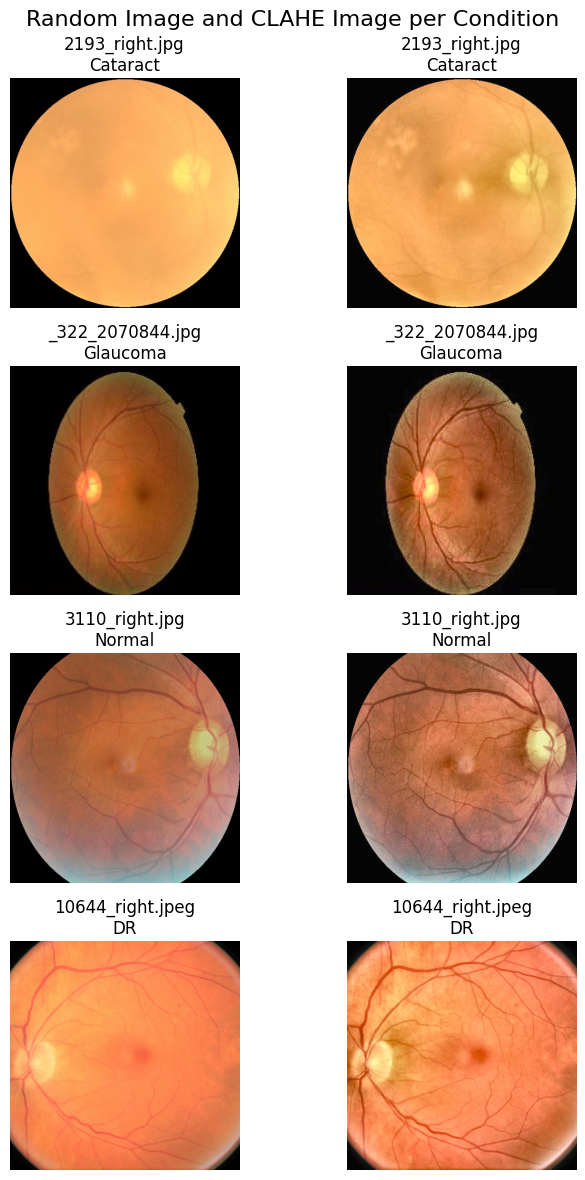

In [34]:
# def display_one_random_image_per_condition(original_links, clahe_images, labels):
#    
#     # Define the mapping of conditions to numerical labels
#     condition_map = {
#         'Cataract': 0,
#         'Glaucoma': 1,
#         'Normal': 2,
#         'DR': 3
#     }
#     # Create a reverse map for label numbers to conditions
#     reverse_map = {v: k for k, v in condition_map.items()}
# 
#     # Group images by their labels
#     grouped_images = {label: [] for label in condition_map.values()}
#     
#     # Group original links by labels
#     for link, label in zip(original_links, labels):
#         grouped_images[label].append(link)
# 
#     # Randomly select one image from each condition group
#     selected_indices = []
#     for label in condition_map.values():
#         if grouped_images[label]:  # Check if there are images for the label
#             selected_image = random.choice(grouped_images[label])
#             # Append the index of the selected image in the original_links
#             selected_indices.append(np.where(original_links == selected_image)[0][0])
# 
#     # Set up the figure for displaying images
#     num_images = len(selected_indices)
#     fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
#     
#     for i, idx in enumerate(selected_indices):
#         # Load original image
#         original_img = cv2.imread(original_links[idx])
#         if original_img is not None:
#             original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
#             axs[i, 0].imshow(original_img)
#             axs[i, 0].axis('off')  # Hide axes
#             image_name = os.path.basename(original_links[idx])
#             label_str = reverse_map.get(labels[idx], "Unknown")  # Get label string or "Unknown"
#             axs[i, 0].set_title(f"{image_name}\n{label_str}")
#         else:
#             axs[i, 0].set_title("Original Image Not Found")
#             axs[i, 0].axis('off')  # Hide axes for missing images
# 
#         # Show CLAHE image
#         axs[i, 1].imshow(cv2.cvtColor(clahe_images[idx], cv2.COLOR_RGB2BGR))
#         axs[i, 1].axis('off')  # Hide axes
#         axs[i, 1].set_title(f"{image_name}\n{label_str}")
# 
#     # Adjust subplot spacing (increase space between images without resizing them)
#     plt.subplots_adjust(wspace=1, hspace=1)  # Increase the space between the images
# 
#     # Add a title to the entire figure
#     plt.suptitle("Random Image and CLAHE Image per Condition", fontsize=16)
# 
#     plt.tight_layout()  # Adjust layout to fit the title
#     plt.tight_layout() 
#     plt.show()
# 
# display_one_random_image_per_condition(train_links, train_images, train_labels)  

In [9]:

# # Check if all images have the same shape and resize if necessary
# def resize_images(images_list):
#     resized_images = []
#     consistent_shape = (256, 256, 3)  # Assuming RGB images with shape (256, 256, 3)
#     for img in images_list:
#         if img.shape != consistent_shape:
#             resized_img = cv2.resize(img, (consistent_shape[1], consistent_shape[0]))
#             resized_images.append(resized_img)
#         else:
#             resized_images.append(img)
#     return resized_images
# 
# # Resize images to ensure consistent shapes
# train_images = resize_images(train_images)
# val_images = resize_images(val_images)
# test_images = resize_images(test_images)

# Now convert the lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

val_images = np.array(val_images)
val_labels = np.array(val_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)


In [10]:
# Save all data in a single .npz file
np.savez('C:/Users/PC_I/OneDrive/Desktop/EDC/datasetWithoutCLAHE.npz', 
         train_images=train_images, 
         train_labels=train_labels, 
         val_images=val_images, 
         val_labels=val_labels, 
         test_images=test_images, 
         test_labels=test_labels)


In [36]:
print(type(train_images))  # <class 'list'>
print(type(train_images[0]))  # <class 'numpy.ndarray'> (for each individual image)
print(type(train_labels))  # <class 'list'>
print(type(train_labels[0]))  # <class 'int'> or <class 'str'> depending on your label type
print(train_images[:5],train_links[:5], train_labels[:5])

print(train_images.shape)  # Check the shape to verify consistency

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>
[[[[4 4 4]
   [4 4 4]
   [4 4 4]
   ...
   [4 4 4]
   [4 4 4]
   [4 4 4]]

  [[4 4 4]
   [4 4 4]
   [4 4 4]
   ...
   [4 4 4]
   [4 4 4]
   [4 4 4]]

  [[4 4 4]
   [4 4 4]
   [4 4 4]
   ...
   [4 4 4]
   [4 4 4]
   [4 4 4]]

  ...

  [[4 4 4]
   [4 4 4]
   [4 4 4]
   ...
   [4 4 4]
   [4 4 4]
   [4 4 4]]

  [[4 4 4]
   [4 4 4]
   [4 4 4]
   ...
   [4 4 4]
   [4 4 4]
   [4 4 4]]

  [[4 4 4]
   [4 4 4]
   [4 4 4]
   ...
   [4 4 4]
   [4 4 4]
   [4 4 4]]]


 [[[4 4 4]
   [4 4 4]
   [4 4 4]
   ...
   [4 4 4]
   [4 4 4]
   [4 4 4]]

  [[4 4 4]
   [4 4 4]
   [4 4 4]
   ...
   [4 4 4]
   [4 4 4]
   [4 4 4]]

  [[4 4 4]
   [4 4 4]
   [4 4 4]
   ...
   [4 4 4]
   [4 4 4]
   [4 4 4]]

  ...

  [[8 3 6]
   [8 3 6]
   [8 3 6]
   ...
   [6 4 6]
   [8 3 6]
   [7 3 6]]

  [[8 3 6]
   [8 3 6]
   [8 3 6]
   ...
   [6 4 6]
   [8 3 6]
   [8 3 6]]

  [[8 3 6]
   [8 3 6]
   [8 3 6]
   ...
   [8 3 6]
   [8 3 6]
   

In [5]:
# Function to decode images based on file type
def decode_image(path):
    # Read the image file
    image = tf.io.read_file(path)

    # Extract file extension
    file_extension = tf.strings.split(path, '.')[-1]

    # Conditional decoding based on the file type
    def decode_jpeg(): return tf.image.decode_jpeg(image, channels=3)
    def decode_png(): return tf.image.decode_png(image, channels=3)
    def decode_bmp(): return tf.image.decode_bmp(image, channels=3)
    def decode_gif(): return tf.squeeze(tf.image.decode_gif(image), axis=0)

    # Handle each format using tf.cond
    image = tf.cond(tf.math.equal(file_extension, 'jpg'), decode_jpeg,
             lambda: tf.cond(tf.math.equal(file_extension, 'jpeg'), decode_jpeg,
             lambda: tf.cond(tf.math.equal(file_extension, 'png'), decode_png,
             lambda: tf.cond(tf.math.equal(file_extension, 'bmp'), decode_bmp,
             lambda: tf.cond(tf.math.equal(file_extension, 'gif'), decode_gif,
                             decode_jpeg)))))
    return image

# Function to normalize the image
def normalize_images(image):
    # Assuming the images are already resized, only normalize them
    # Cast the image to float32 before normalization
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # Normalize to [0, 1] range
    return image

# Function to augment the image
def augment_image(image):
    # Randomly flip the image horizontally and vertically
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    # Randomly rotate the image
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Randomly adjust brightness
    #image = tf.image.random_brightness(image, max_delta=0.1)
    # Randomly adjust contrast
    #image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Randomly zoom in
    image = tf.image.resize_with_crop_or_pad(image, 266, 266)  # Zoom in slightly
    image = tf.image.random_crop(image, size=[256, 256, 3])
    
    # Clip the image to ensure values are in the range [0, 1]
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    
    return image

# Combined function that loads and preprocesses the image
def load_and_preprocess_image(image, label, data_augmentation=True):
    
    # Decode the image
    #image = decode_image(path)
      
    # Normalize and resize the image
    image = normalize_images(image)
 
    # Apply data augmentation if specified
    if data_augmentation:
        image = augment_image(image)
        #print(f"After data augmentation: {image.shape,image.dtype}") 
    
    return image, label


In [6]:
# create TensorFlow datasets for each split
# When loading datasets, pass the data_augmentation flag True or False to apply or skip augmentations:
train_dataset = tf.data.Dataset.from_tensor_slices( (train_images , train_labels) )
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=True), num_parallel_calls=tf.data.AUTOTUNE)
# the augmentations will be applied automatically every time you fetch an image from the train_dataset while data_augmentation=True
# During the training process, each time the model accesses train_dataset, it retrieves the images along with their augmentations.

val_dataset = tf.data.Dataset.from_tensor_slices( (val_images , val_labels) )
val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices( (test_images , test_labels) )
test_dataset = test_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

NameError: name 'train_images' is not defined

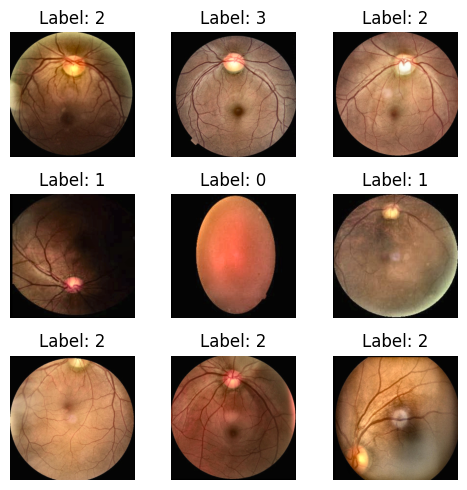

In [4]:
def display_sample_grid(dataset, num_samples=9, grid_size=(3, 3)):
    # Set up the grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(5, 5))
    
    # Flatten the axes for easy iteration
    axes = axes.flatten()
    
    # Take the specified number of samples from the dataset
    for idx, (image, label) in enumerate(dataset.take(num_samples)):
        # Plot each image in the corresponding grid cell
        image = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
        axes[idx].imshow(image)
        
        # Set title to display the label only (no image name available)
        axes[idx].set_title(f'Label: {label.numpy()}')
        axes[idx].axis('off')  # Hide the axes for a cleaner look
    
    plt.tight_layout()  # Adjusts the spacing between subplots
    plt.show()

# Test with training dataset, displaying 9 images in a 3x3 grid
display_sample_grid(train_dataset, num_samples=9, grid_size=(3, 3))


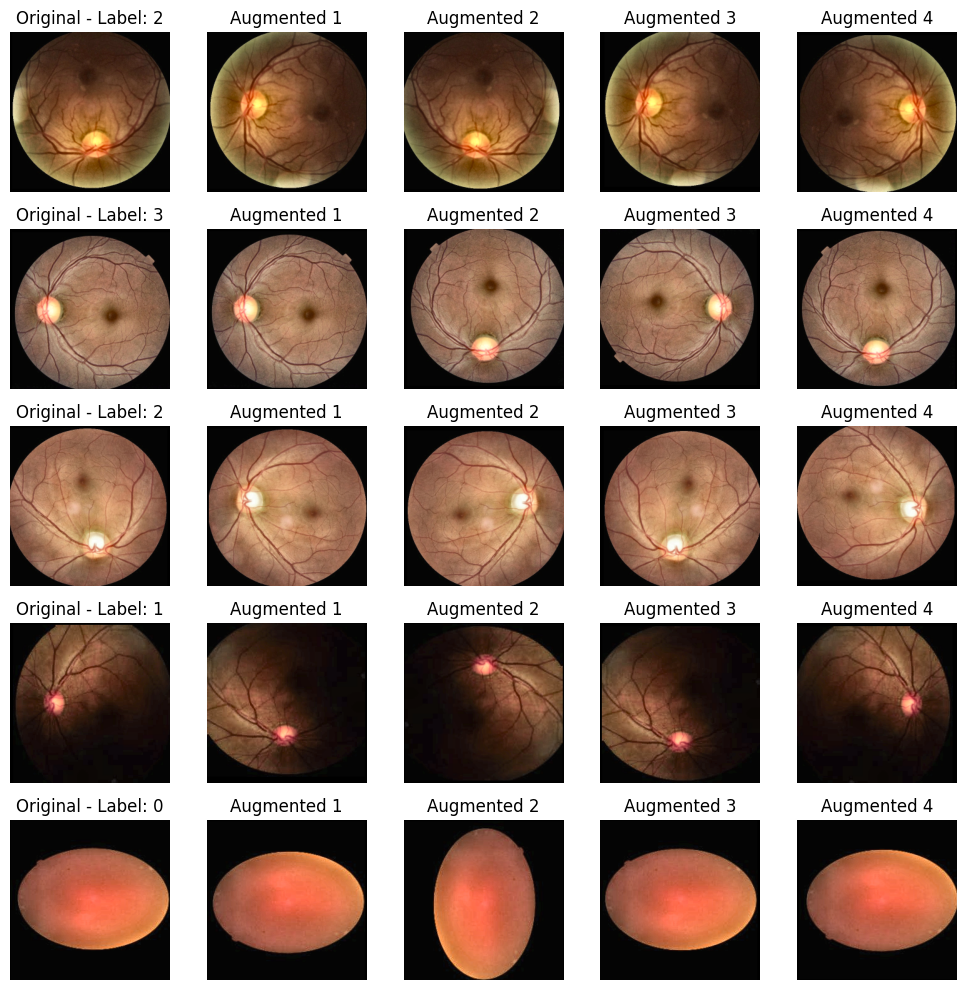

In [23]:
# Function to test augmentation by displaying the same image multiple times in a grid
def test_augmentation(dataset, num_samples=5, repetitions=4):
    # Calculate the total number of images per row (1 original + `repetitions` augmentations)
    total_images = repetitions + 1
    
    # Create a larger grid: `num_samples` rows and `total_images (repetitions + 1)` columns
    plt.figure(figsize=(10,10))  # Adjust figure size based on samples and repetitions

    # Iterate over samples in the dataset
    for row, (image, label) in enumerate(dataset.take(num_samples)):
        # Plot original image in the first column
        plt.subplot(num_samples, total_images, row * total_images + 1)
        image = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
        plt.imshow(image)
        plt.title(f'Original - Label: {label.numpy()}')
        plt.axis('off')

        # Generate and plot augmented images in the remaining columns
        for col in range(repetitions):
            # Apply augmentation
            augmented_image = augment_image(image)

            # Plot augmented image
            plt.subplot(num_samples, total_images, row * total_images + col + 2)
            plt.imshow(augmented_image)
            plt.title(f'Augmented {col+1}')
            plt.axis('off')

    # Adjust layout for better appearance
    plt.tight_layout()
    plt.show()

# Example: Assuming `train_dataset` is a dataset of (image, label) pairs
test_augmentation(train_dataset, num_samples=5, repetitions=4)


In [21]:
 # Save dataset
tf.data.Dataset.save(train_dataset, 'C:/Users/PC_I/OneDrive/Desktop/EDC/TF/withoutBatch/train_dataset')
tf.data.Dataset.save(val_dataset, 'C:/Users/PC_I/OneDrive/Desktop/EDC/TF/withoutBatch/val_dataset')
tf.data.Dataset.save(test_dataset, 'C:/Users/PC_I/OneDrive/Desktop/EDC/TF/withoutBatch/test_dataset')

In [24]:
#prepare your datasets for model training and evaluation

batch_size = 32

train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size= tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000)  # Shuffle with buffer size

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
 

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
# Load datasets from the specified directory
train_dataset = tf.data.Dataset.load('C:/Users/PC_I/OneDrive/Desktop/EDC/TF/withoutBatch/train_dataset')
val_dataset = tf.data.Dataset.load('C:/Users/PC_I/OneDrive/Desktop/EDC/TF/withoutBatch/val_dataset')
test_dataset = tf.data.Dataset.load('C:/Users/PC_I/OneDrive/Desktop/EDC/TF/withoutBatch/test_dataset')


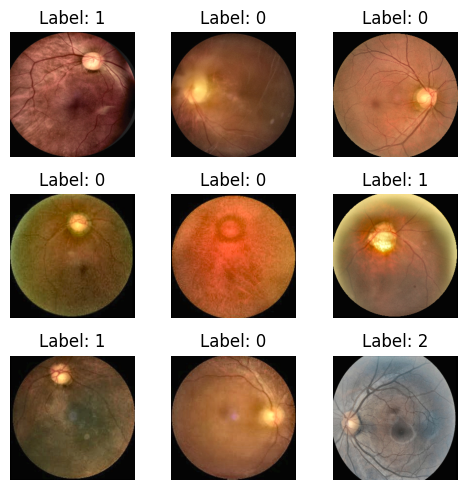

In [26]:

def display_sample_grid(dataset, num_samples=9, grid_size=(3, 3)):
    # Set up the grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(5, 5))
    
    # Flatten the axes for easy iteration
    axes = axes.flatten()
    
    # Take the specified number of samples from the dataset
    count = 0
    for batch_images, batch_labels in dataset:
        for image, label in zip(batch_images, batch_labels):
            if count >= num_samples:
                break
            
            # Convert image from tensor to numpy and from RGB to BGR (for OpenCV compatibility)
            image = image.numpy()  # Convert tensor to numpy
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
            
            # Plot each image in the corresponding grid cell
            axes[count].imshow(image)
            axes[count].set_title(f'Label: {label.numpy()}')
            axes[count].axis('off')  # Hide the axes for a cleaner look
            
            count += 1
        if count >= num_samples:
            break
    
    plt.tight_layout()  # Adjusts the spacing between subplots
    plt.show()

# Test with training dataset, displaying 9 images in a 3x3 grid
display_sample_grid(train_dataset, num_samples=9, grid_size=(3, 3))


In [27]:
# Assuming you have a TensorFlow dataset

# For example: train_dataset, val_dataset, test_dataset
for image, label in train_dataset.take(1):
    print("Data type of images:", image.dtype)
    print("Data type of labels:", label.dtype)
    print("Image batch shape:", image.shape)
    print("Label batch shape:", label.shape)
    
# Images are stored in TensorFlow tensors with the data type float32, meaning the pixel values are floating-point numbers, likely normalized to the range [0, 1]. The labels are stored as int32, which is typical for class labels representing categories.
# Each image is 256x256 pixels with 3 color channels (RGB), and you're working with batches of 32 images and their corresponding labels.

Data type of images: <dtype: 'float32'>
Data type of labels: <dtype: 'int32'>
Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)


In [ ]:


model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3))) # 32 filters, a 3x3 kernel, and ReLU
model.add(layers.MaxPooling2D((2, 2))) # this layer to downsample the image
model.add(layers.BatchNormalization())

# Add another Conv2D layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Add another Conv2D layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Flatten the output before feeding it to fully connected layers
model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='softmax')) # Output layer | we use softmax because it is a multi-class problem

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model. Summary()


In [ ]:
# Define the EarlyStopping callback to monitor the validation accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitoring validation accuracy
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='max',  # Stops training when the quantity monitored has stopped increasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

In [ ]:
# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath=r'C:/Users/PC_I/OneDrive/Desktop/EDC/best_model_custom.h5',  
    monitor='val_loss',  # Change to val_loss to monitor the validation loss
    verbose=1,
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model when the monitored metric has minimized
    
)

In [ ]:
# Fit the model
history = model.fit(
    x = train_dataset,
    validation_data = val_dataset,
    epochs = 30,
    callbacks=[early_stopping , model_checkpoint]  # Add the EarlyStopping callback
)